<a href="https://colab.research.google.com/github/olaff13/pneumoniadetect/blob/master/Pdetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports : 



In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

weights & model :

In [12]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-09-19 18:02:50--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   133MB/s    in 0.6s    

2019-09-19 18:02:51 (133 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [29]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)


unfreeze = False
# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

Data:

In [17]:
os.environ["KAGGLE_USERNAME"] = "olaff13"
os.environ["KAGGLE_KEY"] = "e66d1df205c966dd47eb2f88d047547b"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:14<00:00, 109MB/s]
100% 1.15G/1.15G [00:14<00:00, 86.0MB/s]


In [18]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

In [32]:
# Define our example directories and files
base_dir = '/content/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training NORMAL pictures
train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')

# Directory with our training PNEUMONIA pictures
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

# Directory with our validation NORMAL pictures
validation_NORMAL_dir = os.path.join(validation_dir, 'NORMAL')

# Directory with our validation PNEUMONIA pictures
validation_PNEUMONIA_dir = os.path.join(validation_dir, 'PNEUMONIA')

train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Train model :




In [33]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 227s - loss: 0.6340 - acc: 0.6660 - val_loss: 0.7270 - val_acc: 0.4375
Epoch 2/50
100/100 - 219s - loss: 0.5666 - acc: 0.7480 - val_loss: 0.7369 - val_acc: 0.4375
Epoch 3/50
100/100 - 225s - loss: 0.5513 - acc: 0.7465 - val_loss: 0.7305 - val_acc: 0.4375
Epoch 4/50
100/100 - 219s - loss: 0.5460 - acc: 0.7520 - val_loss: 0.7272 - val_acc: 0.5000
Epoch 5/50
100/100 - 218s - loss: 0.5497 - acc: 0.7310 - val_loss: 0.7002 - val_acc: 0.4375
Epoch 6/50
100/100 - 217s - loss: 0.5301 - acc: 0.7495 - val_loss: 0.6926 - val_acc: 0.4375
Epoch 7/50
100/100 - 217s - loss: 0.5327 - acc: 0.7375 - val_loss: 0.6829 - val_acc: 0.4375
Epoch 8/50
100/100 - 217s - loss: 0.5203 - acc: 0.7380 - val_loss: 0.6728 - val_acc: 0.4375
Epoch 9/50
100/100 - 217s - loss: 0.5016 - acc: 0.7540 - val_loss: 0.6663 - val_acc: 0.5000
Epoch 10/50
100/100 - 220s - loss: 0.5039 - acc: 0.7510 - val_loss: 0.6583 - val_acc: 0.6250
Epoch 11/50
100/100 - 219s - loss: 0.5037 - acc: 0.7450 - val_loss: 0.6473 - va

Text(0.5, 1.0, 'Training and validation loss')

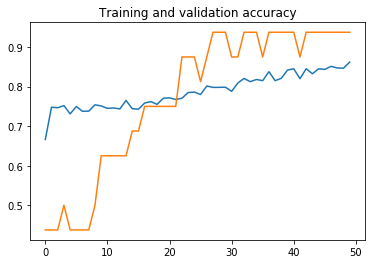

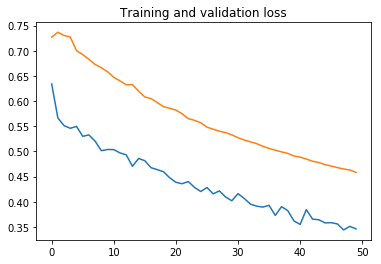

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')